# Estimate covariance matrix of financial time series (FTS)

In [1]:
import re
import sys
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

sys.path.append('../modules')
import estimate_entropy as ee  # type: ignore  # noqa: E402
import estimate_market_factors as emf  # type: ignore  # noqa: E402

warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
# pd.options.display.max_rows = 277

## Global variables

In [2]:
input_path_raw = "../input_files/raw_data"
input_path_processed = "../input_files/processed_data"
input_path_data_dictionary = "../input_files/data_dictionary"
log_path = "../logs"
output_path = "../output_files"
input_generation_date = "2024-08-31"
stock_index_name = "gdaxi"

In [3]:
stock_index_list = {
    "gspc": ["EW", "SWKS"],          # Standard and Poor's 500 - S&P 500 (United States)  # noqa: E501
    "mxx": ["CUERVO.MX", "GCC.MX"],  # Mexico Price and Quote Index (Mexico)
    "gdaxi": ["CBK.DE", "HEN3.DE"]   # DAX Performance Index (Germany)
} 

# Define shares pair
shares_pair = stock_index_list[stock_index_name]

# Load data and filter duplicates by symbol and date
df_stock_index = pd.read_csv("{}/df_all_markets_{}.csv".format(input_path_processed, re.sub("-", "", input_generation_date)), low_memory=False)  # noqa: E501
df_stock_index.drop_duplicates(subset=["date", "symbol"], keep="first", inplace=True, ignore_index=True)  # noqa: E501
df_stock_index["date"] = pd.to_datetime(df_stock_index["date"], errors="coerce")  # noqa: E501
df_stock_index = df_stock_index[df_stock_index["market_ticker"] == "^GDAXI"]

## Entropy matrix (proof)

In [4]:
ee.estimate_entropy_pairs(
    df=df_stock_index,
    precision=12,
    column_="z_score_log_return",
    log_path=log_path,
    log_filename="log_entropy_proof_{}".format(stock_index_name),
    verbose=1,
    entropy_args_list=(shares_pair[0], shares_pair[1], 76, 50)
)


,symbol_x,symbol_y,entropy_x,entropy_y,joint_entropy,mutual_information,shared_information,rajski_distance
0,CBK.DE,HEN3.DE,2.828698,0.734686,3.514439,0.048945,3.465494,0.013927
1,HEN3.DE,CBK.DE,2.828698,0.734686,3.514439,0.048945,3.465494,0.013927


In [5]:
ee.estimate_entropy_matrix(
    df=df_stock_index[df_stock_index["symbol"].isin(shares_pair)],
    min_bins=10,
    precision=12,
    column_="z_score_log_return",
    log_path=log_path,
    log_filename="log_entropy_proof_{}".format(stock_index_name),
    verbose=1,
    tqdm_bar=True
)

100%|█████████████████████████| 3/3 [00:00<00:00, 89.75it/s]


,symbol_x,symbol_y,entropy_x,entropy_y,joint_entropy,mutual_information,shared_information,rajski_distance
0,CBK.DE,CBK.DE,2.854914,2.854914,2.854914,2.854914,0.000000,1.000000
0,CBK.DE,HEN3.DE,2.854914,0.920629,3.705087,0.070456,3.634631,0.019016
1,HEN3.DE,CBK.DE,2.854914,0.920629,3.705087,0.070456,3.634631,0.019016
0,HEN3.DE,HEN3.DE,0.920629,0.920629,0.920629,0.920629,0.000000,1.000000


## Construct covariance matrix and compare with entropy matrix

In [6]:
if stock_index_name == "gspc":
    df_aux = df_stock_index[df_stock_index["symbol"].str.contains("(W)|(Z)")]
else:
    df_aux = df_stock_index

df_final = emf.get_market_efficiency_data_window(
    df=df_aux,
    column_="z_score_log_return",
    min_bins=10,
    precision=12,
    log_path=log_path,
    log_filename="log_entropy_efficiency_{}".format(stock_index_name),
    log_filename_entropy="log_entropy_proof_{}".format(stock_index_name),
    verbose=1,
    tqdm_bar=True,
    market_args_list=("2015-01-01", "2017-12-31")
)

df_final[df_final["symbol_x"] != df_final["symbol_y"]].drop_duplicates().sort_values(["correlation", "rajski_distance"], ascending=[True, True])  # noqa: E501


100%|████████████████████| 741/741 [00:05<00:00, 135.78it/s]


,initial_date,final_date,symbol_x,symbol_y,entropy_x,entropy_y,joint_entropy,mutual_information,shared_information,rajski_distance,modified_rajski_distance,correlation
11,2015-01-01,2017-12-31,1COV.DE,BEI.DE,2.413358,2.511618,4.499305,0.425671,4.073634,0.094608,0.905392,0.207866
12,2015-01-01,2017-12-31,BEI.DE,1COV.DE,2.413358,2.511618,4.499305,0.425671,4.073634,0.094608,0.905392,0.207866
69,2015-01-01,2017-12-31,1COV.DE,VNA.DE,2.413358,2.212977,4.292786,0.333549,3.959236,0.077700,0.922300,0.207981
70,2015-01-01,2017-12-31,VNA.DE,1COV.DE,2.413358,2.212977,4.292786,0.333549,3.959236,0.077700,0.922300,0.207981
1317,2015-01-01,2017-12-31,MUV2.DE,VNA.DE,2.268977,2.212977,4.218923,0.263031,3.955892,0.062346,0.937654,0.218286
...,...,...,...,...,...,...,...,...,...,...,...,...
945,2015-01-01,2017-12-31,RWE.DE,EOAN.DE,2.535360,2.211999,4.101830,0.645528,3.456302,0.157376,0.842624,1.391853
608,2015-01-01,2017-12-31,CBK.DE,DBK.DE,2.032706,2.303982,3.734238,0.602451,3.131787,0.161332,0.838668,1.512265
609,2015-01-01,2017-12-31,DBK.DE,CBK.DE,2.032706,2.303982,3.734238,0.602451,3.131787,0.161332,0.838668,1.512265
1340,2015-01-01,2017-12-31,PAH3.DE,VOW3.DE,2.147383,2.071112,3.342390,0.876105,2.466284,0.262119,0.737881,1.625884


In [7]:
df_final_2 = emf.get_market_efficiency_data_window(
    df=df_aux,
    column_="z_score_zlr_no_market",
    min_bins=10,
    precision=12,
    log_path=log_path,
    log_filename="log_entropy_efficiency_residuals_{}".format(stock_index_name),
    log_filename_entropy="log_entropy_proof_residuals_{}".format(stock_index_name),
    verbose=1,
    tqdm_bar=True,
    market_args_list=("2015-01-01", "2017-12-31")
)

df_final_2[df_final_2["symbol_x"] != df_final_2["symbol_y"]].drop_duplicates().sort_values(["correlation", "rajski_distance"], ascending=[True, True])  # noqa: E501


100%|████████████████████| 741/741 [00:06<00:00, 122.63it/s]


,initial_date,final_date,symbol_x,symbol_y,entropy_x,entropy_y,joint_entropy,mutual_information,shared_information,rajski_distance,modified_rajski_distance,correlation
431,2015-01-01,2017-12-31,BEI.DE,DBK.DE,2.282481,2.527397,4.517113,0.292765,4.224348,0.064812,0.935188,-0.371512
432,2015-01-01,2017-12-31,DBK.DE,BEI.DE,2.282481,2.527397,4.517113,0.292765,4.224348,0.064812,0.935188,-0.371512
461,2015-01-01,2017-12-31,BEI.DE,PAH3.DE,2.282481,1.727553,3.812124,0.197911,3.614213,0.051916,0.948084,-0.335115
462,2015-01-01,2017-12-31,PAH3.DE,BEI.DE,2.282481,1.727553,3.812124,0.197911,3.614213,0.051916,0.948084,-0.335115
425,2015-01-01,2017-12-31,BEI.DE,CBK.DE,2.282481,2.127212,4.193905,0.215789,3.978116,0.051453,0.948547,-0.331498
...,...,...,...,...,...,...,...,...,...,...,...,...
945,2015-01-01,2017-12-31,RWE.DE,EOAN.DE,2.402942,1.957104,3.898882,0.461165,3.437716,0.118281,0.881719,0.623935
608,2015-01-01,2017-12-31,CBK.DE,DBK.DE,2.127212,2.527397,4.201210,0.453399,3.747812,0.107921,0.892079,0.624915
609,2015-01-01,2017-12-31,DBK.DE,CBK.DE,2.127212,2.527397,4.201210,0.453399,3.747812,0.107921,0.892079,0.624915
1340,2015-01-01,2017-12-31,PAH3.DE,VOW3.DE,1.727553,1.747081,2.928542,0.546092,2.382451,0.186472,0.813528,0.878049


In [8]:
emf.get_market_efficiency(
    df=df_aux,
    column_="z_score_log_return",
    min_bins=10,
    precision=12,
    log_path=log_path,
    log_filename="log_market_efficiency_{}".format(stock_index_name),
    log_filename_entropy="log_entropy_final_{}".format(stock_index_name),
    verbose=1,
    tqdm_bar=True,
    market_args_list=("2015-01-01", "2017-01-01"),
    bouchaud_filter=False,
    n=int(df_aux.shape[0] * 8),
    df_tracy_widom=pd.read_csv("{}/tracy_widom.csv".format(input_path_data_dictionary), low_memory=False),  # noqa: E501
    alphas=[0.01, 0.05, 0.10],
    k_max=8,
    df_onatski=pd.read_csv("{}/onatski.csv".format(input_path_data_dictionary), low_memory=False),  # noqa: E501
    levels=[1, 2, 5, 10]
)[0]

100%|████████████████████| 741/741 [00:04<00:00, 181.66it/s]


,initial_date,final_date,column_,dropped_eigen_cov,dropped_eigen_entropy,alpha,n_components_cov,n_components_cov_mp,n_components_entropy,n_components_entropy_mp,level,n_factors_cov,n_factors_entropy,edge_distribution_cov,edge_distribution_entropy
0,2015-01-01,2017-01-01,z_score_log_return,0,0,0.01,5,5,1,1,1,0,0,5.0,8.0
1,2015-01-01,2017-01-01,z_score_log_return,0,0,0.05,5,5,1,1,1,0,0,5.0,8.0
2,2015-01-01,2017-01-01,z_score_log_return,0,0,0.10,5,5,1,1,1,0,0,5.0,8.0
3,2015-01-01,2017-01-01,z_score_log_return,0,0,0.01,5,5,1,1,2,0,0,5.0,8.0
4,2015-01-01,2017-01-01,z_score_log_return,0,0,0.05,5,5,1,1,2,0,0,5.0,8.0
5,2015-01-01,2017-01-01,z_score_log_return,0,0,0.10,5,5,1,1,2,0,0,5.0,8.0
6,2015-01-01,2017-01-01,z_score_log_return,0,0,0.01,5,5,1,1,5,0,0,5.0,8.0
7,2015-01-01,2017-01-01,z_score_log_return,0,0,0.05,5,5,1,1,5,0,0,5.0,8.0
8,2015-01-01,2017-01-01,z_score_log_return,0,0,0.10,5,5,1,1,5,0,0,5.0,8.0
9,2015-01-01,2017-01-01,z_score_log_return,0,0,0.01,5,5,1,1,10,0,0,5.0,8.0


In [9]:
emf.get_market_efficiency(
    df=df_aux,
    column_="z_score_zlr_no_market",
    min_bins=10,
    precision=12,
    log_path=log_path,
    log_filename="log_market_efficiency_residuals_{}".format(stock_index_name),
    log_filename_entropy="log_entropy_final_residuals_{}".format(stock_index_name),
    verbose=1,
    tqdm_bar=True,
    market_args_list=("2015-01-01", "2017-01-01"),
    bouchaud_filter=False,
    n=int(df_aux.shape[0] * 2),
    df_tracy_widom=pd.read_csv("{}/tracy_widom.csv".format(input_path_data_dictionary), low_memory=False),  # noqa: E501
    alphas=[0.01, 0.05, 0.10],
    k_max=8,
    df_onatski=pd.read_csv("{}/onatski.csv".format(input_path_data_dictionary), low_memory=False),  # noqa: E501
    levels=[1, 2, 5, 10]
)[0]

100%|████████████████████| 741/741 [00:05<00:00, 147.66it/s]


,initial_date,final_date,column_,dropped_eigen_cov,dropped_eigen_entropy,alpha,n_components_cov,n_components_cov_mp,n_components_entropy,n_components_entropy_mp,level,n_factors_cov,n_factors_entropy,edge_distribution_cov,edge_distribution_entropy
0,2015-01-01,2017-01-01,z_score_zlr_no_market,0,0,0.01,12,12,1,1,1,0,0,2.0,8.0
1,2015-01-01,2017-01-01,z_score_zlr_no_market,0,0,0.05,12,12,1,1,1,0,0,2.0,8.0
2,2015-01-01,2017-01-01,z_score_zlr_no_market,0,0,0.10,12,12,1,1,1,0,0,2.0,8.0
3,2015-01-01,2017-01-01,z_score_zlr_no_market,0,0,0.01,12,12,1,1,2,0,0,2.0,8.0
4,2015-01-01,2017-01-01,z_score_zlr_no_market,0,0,0.05,12,12,1,1,2,0,0,2.0,8.0
5,2015-01-01,2017-01-01,z_score_zlr_no_market,0,0,0.10,12,12,1,1,2,0,0,2.0,8.0
6,2015-01-01,2017-01-01,z_score_zlr_no_market,0,0,0.01,12,12,1,1,5,0,0,2.0,8.0
7,2015-01-01,2017-01-01,z_score_zlr_no_market,0,0,0.05,12,12,1,1,5,0,0,2.0,8.0
8,2015-01-01,2017-01-01,z_score_zlr_no_market,0,0,0.10,12,12,1,1,5,0,0,2.0,8.0
9,2015-01-01,2017-01-01,z_score_zlr_no_market,0,0,0.01,12,12,1,1,10,0,0,2.0,8.0


## Compare spectrum

In [10]:
from scipy.linalg import eigh  # type: ignore  # noqa: E402

df_1 = (
    df_final[["symbol_x", "symbol_y", "correlation"]]
        .sort_values(["symbol_x", "symbol_y", "correlation"], ascending=[True, True, False])  # noqa: E501
        .drop_duplicates(subset=["symbol_x", "symbol_y"])
        .pivot(index="symbol_x", columns="symbol_y", values="correlation")
)

df_2 = (
    df_final[["symbol_x", "symbol_y", "rajski_distance"]]
        .sort_values(["symbol_x", "symbol_y", "rajski_distance"], ascending=[True, True, False])  # noqa: E501
        .drop_duplicates(subset=["symbol_x", "symbol_y"])
        .pivot(index="symbol_x", columns="symbol_y", values="rajski_distance")
)

df_3 = (
    df_final[["symbol_x", "symbol_y", "modified_rajski_distance"]]
        .sort_values(["symbol_x", "symbol_y", "modified_rajski_distance"], ascending=[True, True, False])  # noqa: E501
        .drop_duplicates(subset=["symbol_x", "symbol_y"])
        .pivot(index="symbol_x", columns="symbol_y", values="modified_rajski_distance")
)

df_4 = (
    df_final[["symbol_x", "symbol_y", "shared_information"]]
        .sort_values(["symbol_x", "symbol_y", "shared_information"], ascending=[True, True, False])  # noqa: E501
        .drop_duplicates(subset=["symbol_x", "symbol_y"])
        .pivot(index="symbol_x", columns="symbol_y", values="shared_information")
)

df_5 = (
    df_final_2[["symbol_x", "symbol_y", "correlation"]]
        .sort_values(["symbol_x", "symbol_y", "correlation"], ascending=[True, True, False])  # noqa: E501
        .drop_duplicates(subset=["symbol_x", "symbol_y"])
        .pivot(index="symbol_x", columns="symbol_y", values="correlation")
)

df_6 = (
    df_final_2[["symbol_x", "symbol_y", "rajski_distance"]]
        .sort_values(["symbol_x", "symbol_y", "rajski_distance"], ascending=[True, True, False])  # noqa: E501
        .drop_duplicates(subset=["symbol_x", "symbol_y"])
        .pivot(index="symbol_x", columns="symbol_y", values="rajski_distance")
)

df_7 = (
    df_final_2[["symbol_x", "symbol_y", "modified_rajski_distance"]]
        .sort_values(["symbol_x", "symbol_y", "modified_rajski_distance"], ascending=[True, True, False])  # noqa: E501
        .drop_duplicates(subset=["symbol_x", "symbol_y"])
        .pivot(index="symbol_x", columns="symbol_y", values="modified_rajski_distance")
)

df_8 = (
    df_final_2[["symbol_x", "symbol_y", "shared_information"]]
        .sort_values(["symbol_x", "symbol_y", "shared_information"], ascending=[True, True, False])  # noqa: E501
        .drop_duplicates(subset=["symbol_x", "symbol_y"])
        .pivot(index="symbol_x", columns="symbol_y", values="shared_information")
)

df_9 = pd.DataFrame(
    {
        "marchenko_pastur_upper_bound": np.power(1 + np.sqrt(df_1.shape[0] / df_aux.shape[0]), 2),  # noqa: E501
        "eigenvalues_correlation": eigh(df_1)[0],
        "eigenvalues_entropy": eigh(df_2)[0],
        "eigenvalues_entropy_modified": eigh(df_3)[0],
        "eigenvalues_entropy_shared": eigh(df_4)[0],
        "eigenvalues_correlation_res": eigh(df_5)[0],
        "eigenvalues_entropy_res": eigh(df_6)[0],
        "eigenvalues_entropy_modified_res": eigh(df_7)[0],
        "eigenvalues_entropy_shared_res": eigh(df_8)[0]
    }
)

df_9 = df_9.reindex(index=df_9.index[::-1]).reset_index(drop=True)
df_9

,marchenko_pastur_upper_bound,eigenvalues_correlation,eigenvalues_entropy,eigenvalues_entropy_modified,eigenvalues_entropy_shared,eigenvalues_correlation_res,eigenvalues_entropy_res,eigenvalues_entropy_modified_res,eigenvalues_entropy_shared_res
0,1.026488,17.918436,4.023747,34.040001,149.777687,4.324274,2.507643,35.509331,148.882779
1,1.026488,2.448907,1.248208,-0.735834,-2.452755,2.722927,1.132951,-0.812056,-2.375668
2,1.026488,2.271252,1.098317,-0.778003,-3.071265,2.175185,1.057356,-0.871950,-3.256718
3,1.026488,1.836902,1.060300,-0.818621,-3.116772,2.030607,1.036017,-0.887593,-3.303497
4,1.026488,1.390691,1.022720,-0.829915,-3.170582,1.698216,1.030007,-0.892787,-3.442820
5,1.026488,1.037152,1.011754,-0.835514,-3.356039,1.521775,1.011233,-0.901561,-3.453540
6,1.026488,0.907579,0.981434,-0.842923,-3.400849,1.441216,1.000839,-0.911560,-3.485929
7,1.026488,0.866139,0.976459,-0.844413,-3.428430,1.306423,0.998538,-0.914381,-3.563057
8,1.026488,0.752327,0.969884,-0.850622,-3.498063,1.233497,0.987102,-0.918839,-3.601086
9,1.026488,0.642553,0.953918,-0.854898,-3.595966,1.173886,0.984920,-0.933076,-3.608677


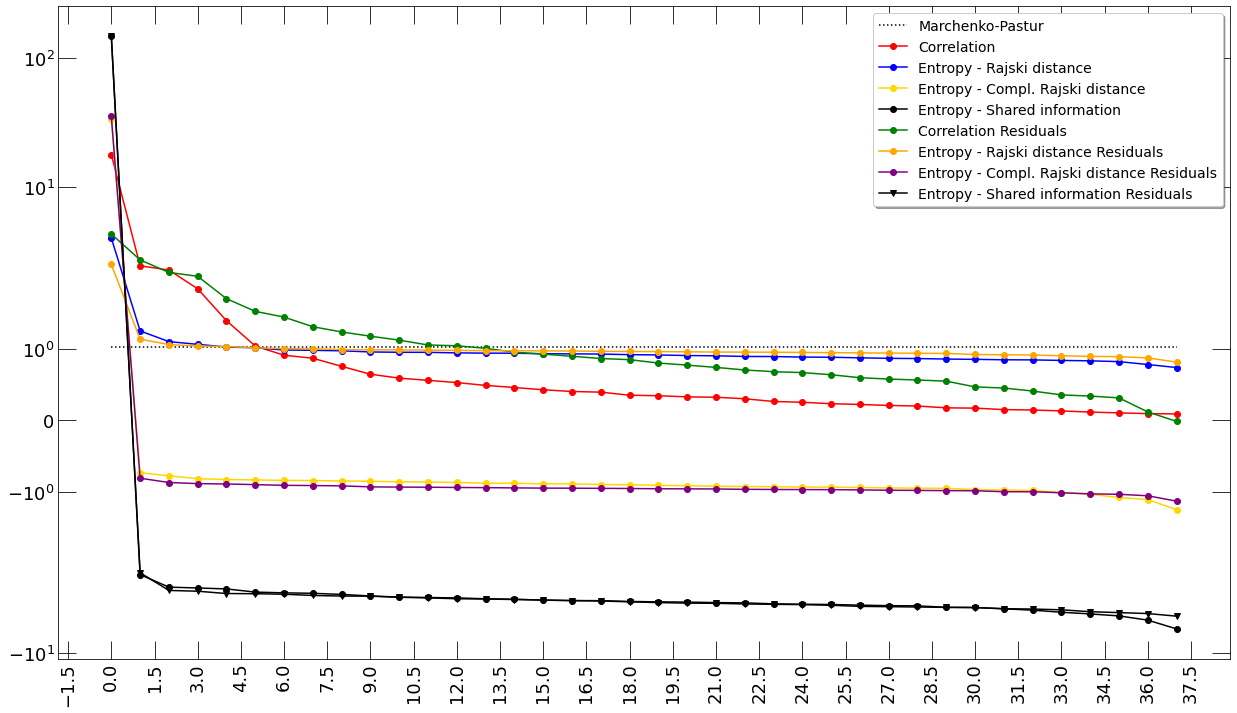

In [11]:
import matplotlib.pyplot as plt  # type: ignore  # noqa: E402
import matplotlib.ticker as mtick  # type: ignore  # noqa: E402

fig, ax = plt.subplots()
fig.set_size_inches(w=21, h=12)

df_10 = df_9  # .tail(5)

ax.plot(df_10["marchenko_pastur_upper_bound"], color="black", marker="", linestyle="dotted", label="Marchenko-Pastur")  # noqa: E501
ax.plot(df_10["eigenvalues_correlation"], color="red", marker="o", label="Correlation")  # noqa: E501
ax.plot(df_10["eigenvalues_entropy"], color="blue", marker="o", label="Entropy - Rajski distance")  # noqa: E501
ax.plot(df_10["eigenvalues_entropy_modified"], color="gold", marker="o", label="Entropy - Compl. Rajski distance")  # noqa: E501
ax.plot(df_10["eigenvalues_entropy_shared"], color="black", marker="o", label="Entropy - Shared information")  # noqa: E501
ax.plot(df_10["eigenvalues_correlation_res"], color="green", marker="o", label="Correlation Residuals")  # noqa: E501
ax.plot(df_10["eigenvalues_entropy_res"], color="orange", marker="o", label="Entropy - Rajski distance Residuals")  # noqa: E501
ax.plot(df_10["eigenvalues_entropy_modified_res"], color="purple", marker="o", label="Entropy - Compl. Rajski distance Residuals")  # noqa: E501
ax.plot(df_10["eigenvalues_entropy_shared_res"], color="black", marker="v", label="Entropy - Shared information Residuals")  # noqa: E501

ax.tick_params(which="major", direction="in", top=True, right=True, labelsize=18, length=18)  # noqa: E501
ax.tick_params(which="minor", direction="in", top=True, right=True, labelsize=18, length=10)  # noqa: E501
ax.xaxis.set_major_locator(mtick.MaxNLocator(df_7.shape[0]))
ax.yaxis.set_major_locator(mtick.MaxNLocator(40))
ax.tick_params(axis="x", labelrotation=90)
ax.legend(fancybox=True, shadow=True, ncol=1, fontsize=14)

# ax.set_xscale(value="log")
ax.set_yscale(value="symlog")

plt.show()


## Exploratory Data Analysis

symbol       date    CBK.DE   HEN3.DE    temp_1    temp_2  mask
0      2000-01-04  0.000000  0.000000  0.000000  0.000000     1
1      2000-01-05 -0.954032  0.139957 -0.954032  0.139957     0
2      2000-01-06  0.506184 -1.708046  0.506184 -1.708046     1
3      2000-01-07  1.116198  0.853144  1.116198  0.853144     1
4      2000-01-10 -0.058171  0.592990 -0.058171  0.592990     0


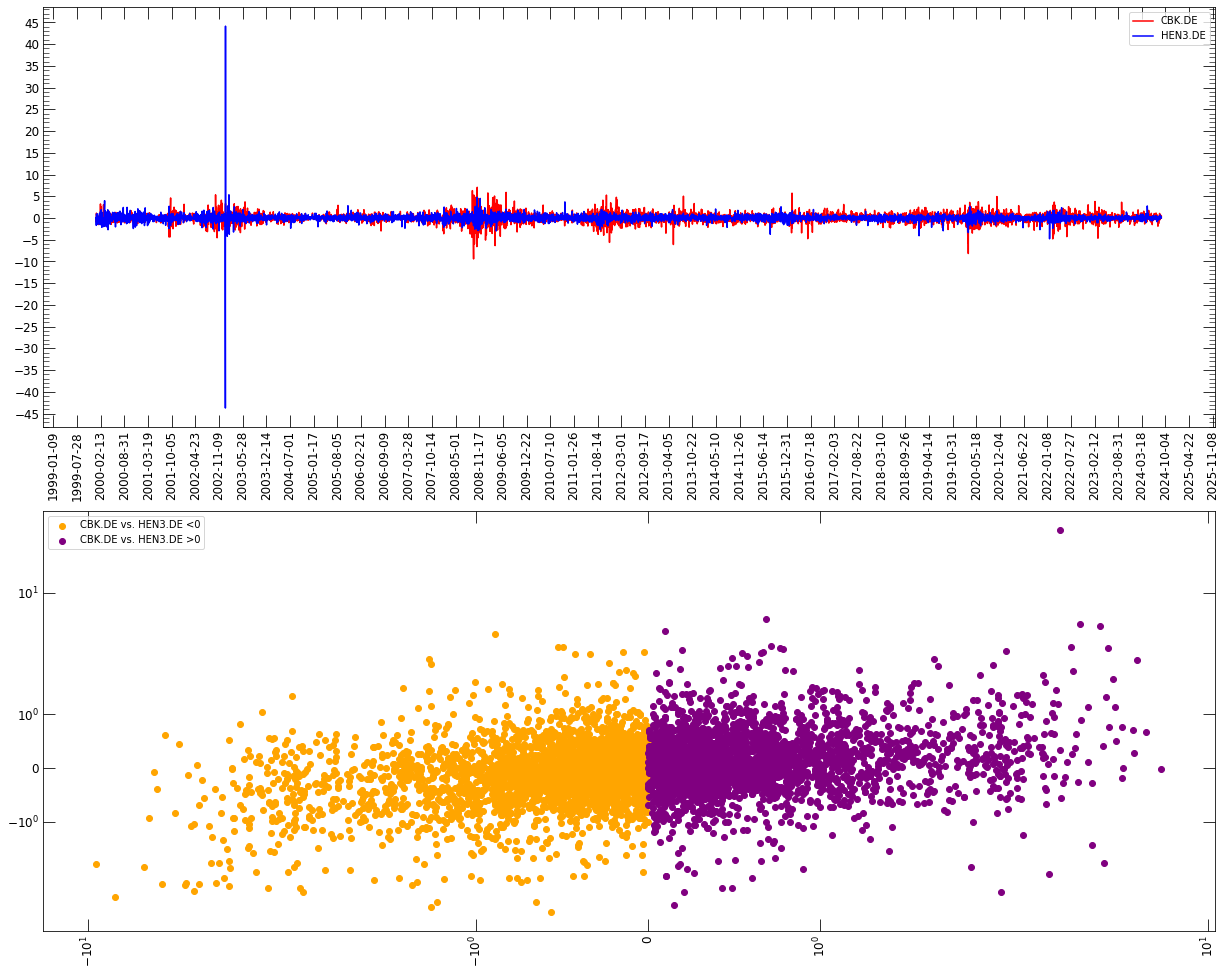

In [12]:
column_ = "z_score_log_return"

import matplotlib.pyplot as plt  # type: ignore  # noqa: E402
import matplotlib.ticker as mtick  # type: ignore  # noqa: E402


def symlog(x):
    if x >= 0:
        return np.log(x)
    else:
        return -np.log(-x)


fig, ax = plt.subplots(2, 1)
fig.set_size_inches(w=21, h=17)

df_1 = df_stock_index[df_stock_index["symbol"] == shares_pair[0]]
df_2 = df_stock_index[df_stock_index["symbol"] == shares_pair[1]]
df_3 = (
    df_stock_index[df_stock_index["symbol"].isin(shares_pair)]
    .pivot(index="date", columns="symbol", values=column_)
    .reset_index()
)
df_3["temp_1"] = df_3[shares_pair[0]]  # .apply(lambda x: symlog(x))
df_3["temp_2"] = df_3[shares_pair[1]]  # .apply(lambda x: symlog(x))
df_3["mask"] = 1
df_3["mask"] = df_3["mask"].mask(cond=df_3[shares_pair[0]] < 0, other=0)
# df_3 = df_3[((df_3[s1] <= df_3[s1].quantile(0.95)) & (df_3[s2] <= df_3[s2].quantile(0.95)))]  # noqa: E501
print(df_3.head())

ax[0].plot(df_1["date"], df_1[column_], color="red", label=shares_pair[0])
ax[0].plot(df_2["date"], df_2[column_], color="blue", label=shares_pair[1])
ax[1].scatter(
    df_3[df_3["mask"] == 0]["temp_1"],
    df_3[df_3["mask"] == 0]["temp_2"],
    color="orange",
    label="{} vs. {} <0".format(shares_pair[0], shares_pair[1])
)
ax[1].scatter(
    df_3[df_3["mask"] == 1]["temp_1"],
    df_3[df_3["mask"] == 1]["temp_2"],
    color="purple",
    label="{} vs. {} >0".format(shares_pair[0], shares_pair[1])
)

ax[0].tick_params(which="major", direction="in", top=True, right=True, labelsize=12, length=12)  # noqa: E501
ax[0].tick_params(which="minor", direction="in", top=True, right=True, labelsize=12, length=6)  # noqa: E501
ax[0].xaxis.set_major_locator(mtick.MaxNLocator(60))
ax[0].yaxis.set_major_locator(mtick.MaxNLocator(20))
ax[0].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 20))
ax[0].tick_params(axis="x", labelrotation=90)
ax[0].legend()

ax[1].tick_params(which="major", direction="in", top=True, right=True, labelsize=12, length=12)  # noqa: E501
ax[1].tick_params(which="minor", direction="in", top=True, right=True, labelsize=12, length=6)  # noqa: E501
ax[1].xaxis.set_major_locator(mtick.MaxNLocator(40))
ax[1].xaxis.set_minor_locator(mtick.MaxNLocator(4 * 20))
ax[1].yaxis.set_major_locator(mtick.MaxNLocator(20))
ax[1].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 20))
ax[1].tick_params(axis="x", labelrotation=90)
ax[1].legend()
ax[1].set_xscale(value="symlog")
ax[1].set_yscale(value="symlog")

plt.show()